## Extracción y visualizado de datos

### Importación de librerías

In [39]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from scipy import cluster

### Importación de los datos

In [2]:
url = 'https://raw.githubusercontent.com/JaviARo/Datasets/main/Earthquake_damage'

train_labels = pd.read_csv(f'{url}/train_labels.csv')
train_values = pd.read_csv(f'{url}/train_values.csv')
test_values = pd.read_csv(f'{url}/test_values.csv')

### Visualización de datos

In [5]:
train_labels_shape = train_labels.shape
print(f"Filas: {train_labels_shape[0]}\nColumnas: {train_labels_shape[1]}")
train_labels.head()

Filas: 260601
Columnas: 2


,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [6]:
train_values_shape = train_values.shape
print(f"Filas: {train_values_shape[0]}\nColumnas: {train_values_shape[1]}")
train_values.head()

Filas: 260601
Columnas: 39


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_values_shape = test_values.shape
print(f"Filas: {test_values_shape[0]}\nColumnas: {test_values_shape[1]}")
test_values.head()

Filas: 86868
Columnas: 39


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


## Normalización y limpieza de datos

In [19]:
def RemoveColumns(df, drop_cols):
  if len(drop_cols) > 0:
  	df = df.drop(columns=[drop_cols], axis=1)
  return df

def CategoricalToNumerical(df, categ_cols):
	for col in categ_cols:
		categories = set(df[col])
		categories = list(categories)
		indexes = list(map(lambda tupl: tupl[0], enumerate(categories)))
		df[col].replace(categories, indexes, inplace=True)
	return df

def NumericalDataScalerAndFillNaN(df):
  # Selección de columnas numéricas
  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

  preprocessor_RR = ColumnTransformer(
                    [('scale', MinMaxScaler(), numeric_cols)],remainder='passthrough')

  df[numeric_cols] = preprocessor_RR.fit_transform(df[numeric_cols])
  df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
  return df

def TransformVars(df, drop_cols = [], categ_cols = []):
  df = RemoveColumns(df, drop_cols)
  df = CategoricalToNumerical(df, categ_cols)
  df = NumericalDataScalerAndFillNaN(df)
  return df

In [20]:
earthquake_categ_cols = [
  'land_surface_condition', 
  'foundation_type',
  'roof_type',
  'ground_floor_type',
  'other_floor_type',
  'position',
  'plan_configuration',
  'legal_ownership_status'
]

X = TransformVars(train_values, categ_cols = earthquake_categ_cols)
y = train_labels['building_id']
X.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0.762541,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.027377,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.090170,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.561175,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.191789,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Separación de variables de entrenamiento y test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Selección de características

### SelectKBest

In [32]:
def ApplySelectKBest(X_train, X_test, y_train, k):
	selector = SelectKBest(f_regression, k=k)

	X_train_selected = selector.fit_transform(X_train, y_train)
	X_test_selected = selector.transform(X_test)

	print(f"Mejores {k} columnas = [")
	for col in selector.get_feature_names_out():
		print(f"  \'{col}\'")
	print("]\n")

In [33]:
ApplySelectKBest(X_train, X_test, y_train, 5)
ApplySelectKBest(X_train, X_test, y_train, 9)

Mejores 5 columnas = [
  'position'
  'has_superstructure_mud_mortar_brick'
  'has_superstructure_rc_engineered'
  'has_superstructure_other'
  'has_secondary_use_agriculture'
]

Mejores 9 columnas = [
  'foundation_type'
  'position'
  'has_superstructure_mud_mortar_brick'
  'has_superstructure_cement_mortar_brick'
  'has_superstructure_rc_engineered'
  'has_superstructure_other'
  'has_secondary_use'
  'has_secondary_use_agriculture'
  'has_secondary_use_use_police'
]



### Matriz de correlación

In [66]:
def PlotMatrizCorrelacion(corr_mat_data):
	sns.set()
	data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool)) # Recorta la gráfica

	cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

	plt.figure(figsize = (23, 15))
	# sns.heatmap(X.corr(), square=True, annot=True)
	sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
							annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)')

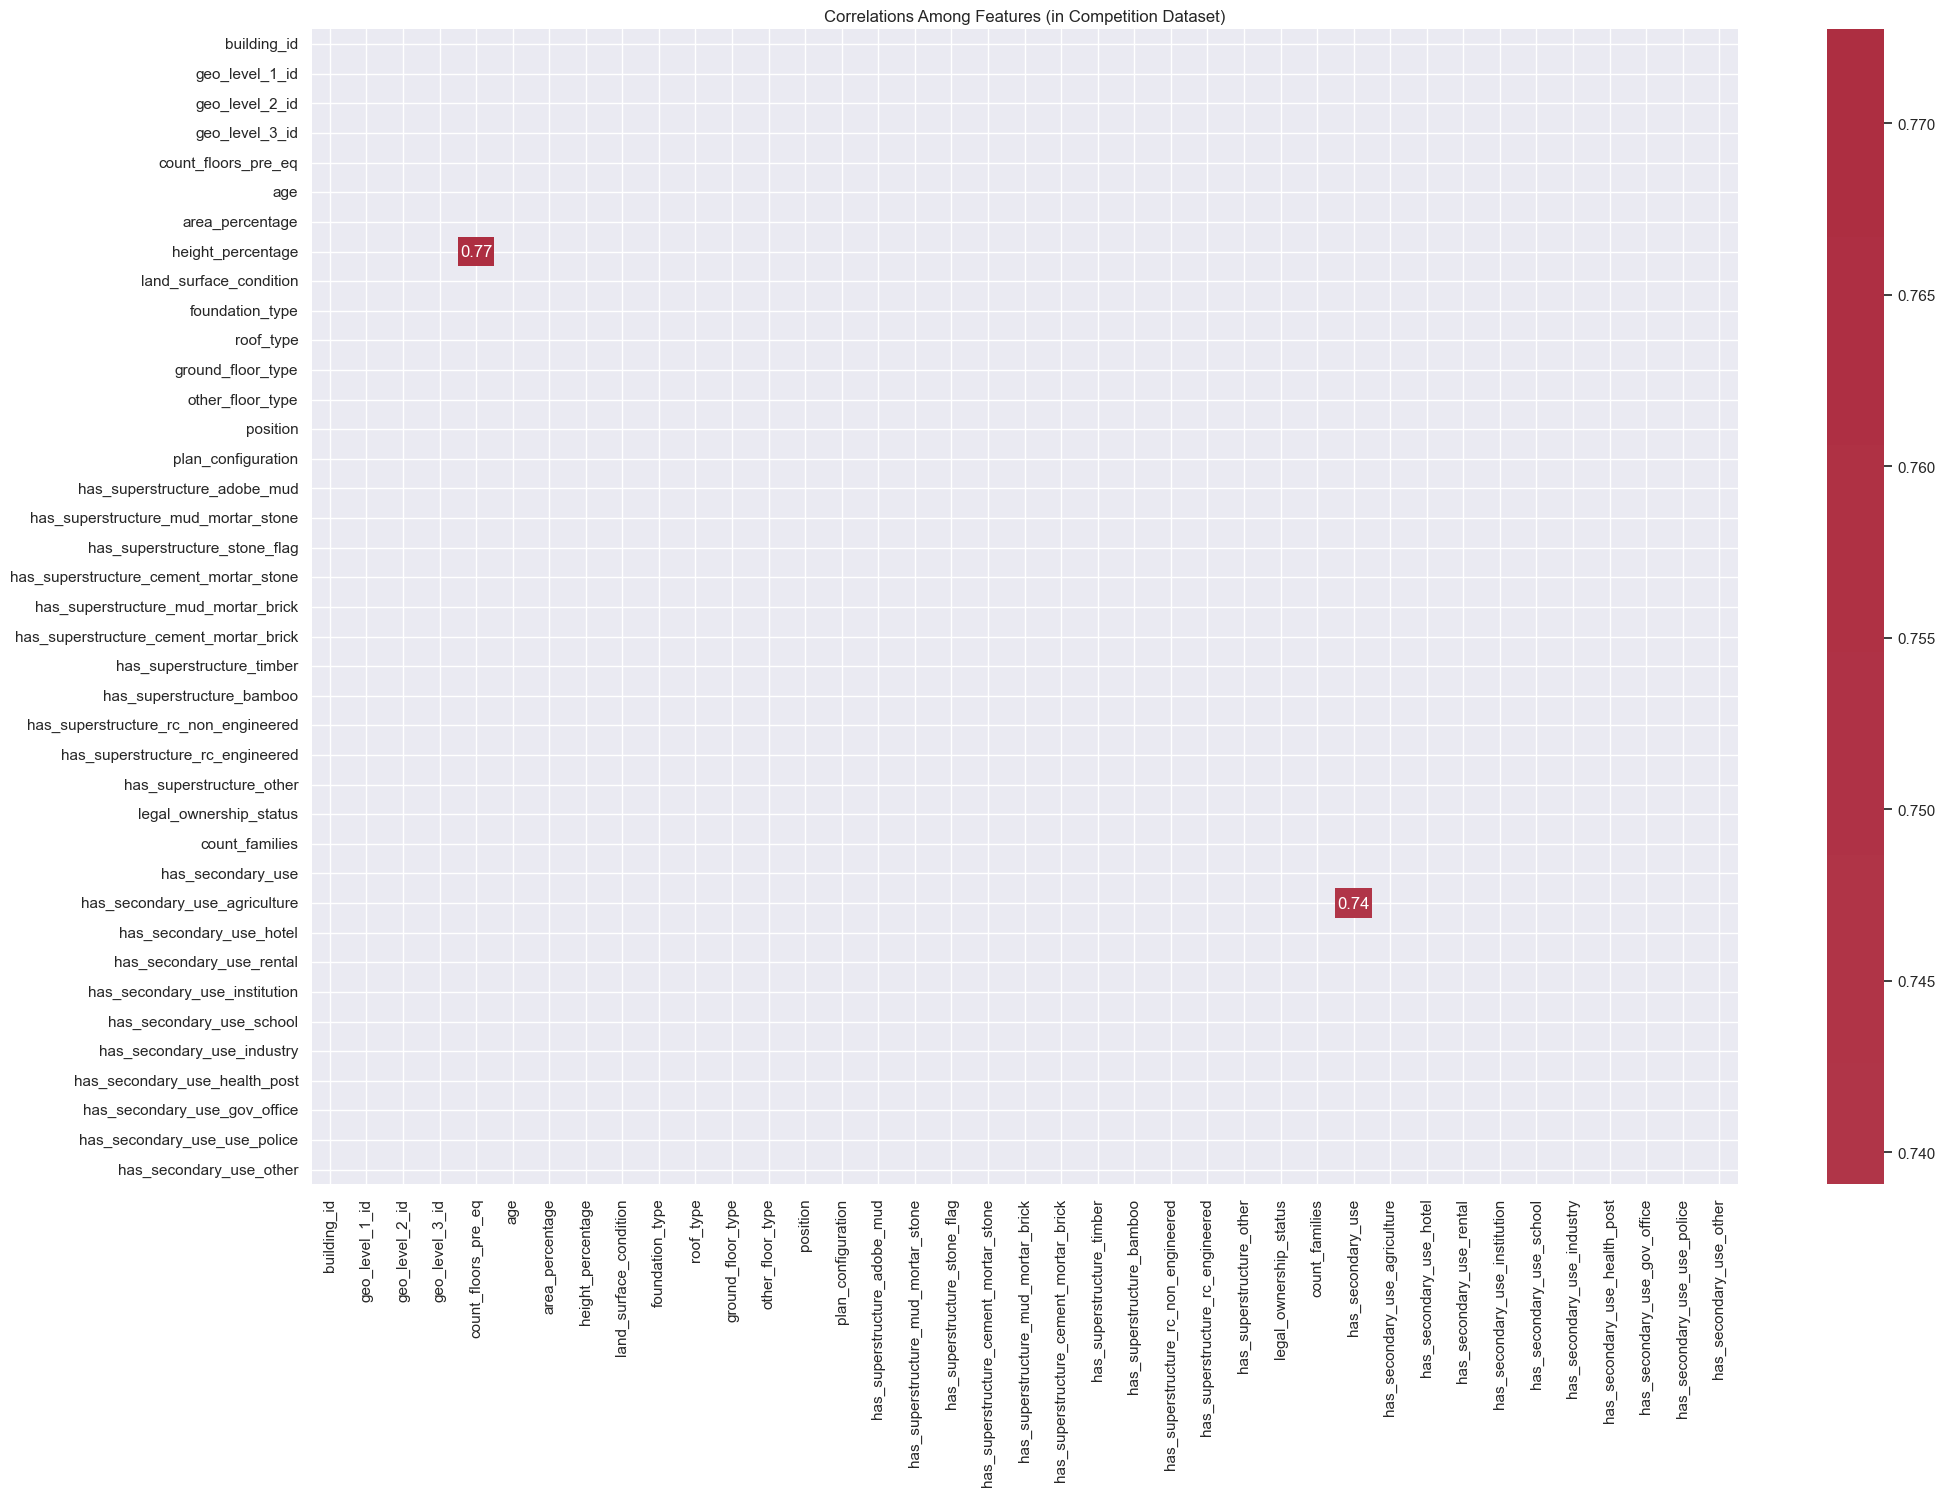

In [68]:
correlation_matrix = X.corr()

# Supongamos que quieres obtener las correlaciones mayores a 0.7
threshold = 0.7
high_correlations = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]

# Imprimir las correlaciones que cumplen el criterio
# print(high_correlations)

PlotMatrizCorrelacion(high_correlations)

### Dendograma

In [42]:
def Dendogram(X, threshold):
	X_T = X.T

	dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
	D = dist.pairwise(X_T)
	avD = np.average(D)
	print("Distancia Media\t {:6.2f}".format(avD))

	plt.figure(figsize=(12, 6))
	plt.title('Dendrograma de dengue')
	plt.xlabel('Columnas')
	plt.ylabel('Distancia')

	clusters = cluster.hierarchy.linkage(D, method='complete')
	cluster.hierarchy.dendrogram(clusters, color_threshold=threshold, labels=X.columns.to_list(), leaf_rotation=90)
	plt.show()

Distancia Media	 178.20


C:\Users\Javi\AppData\Local\Temp\ipykernel_4644\849549956.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='complete')


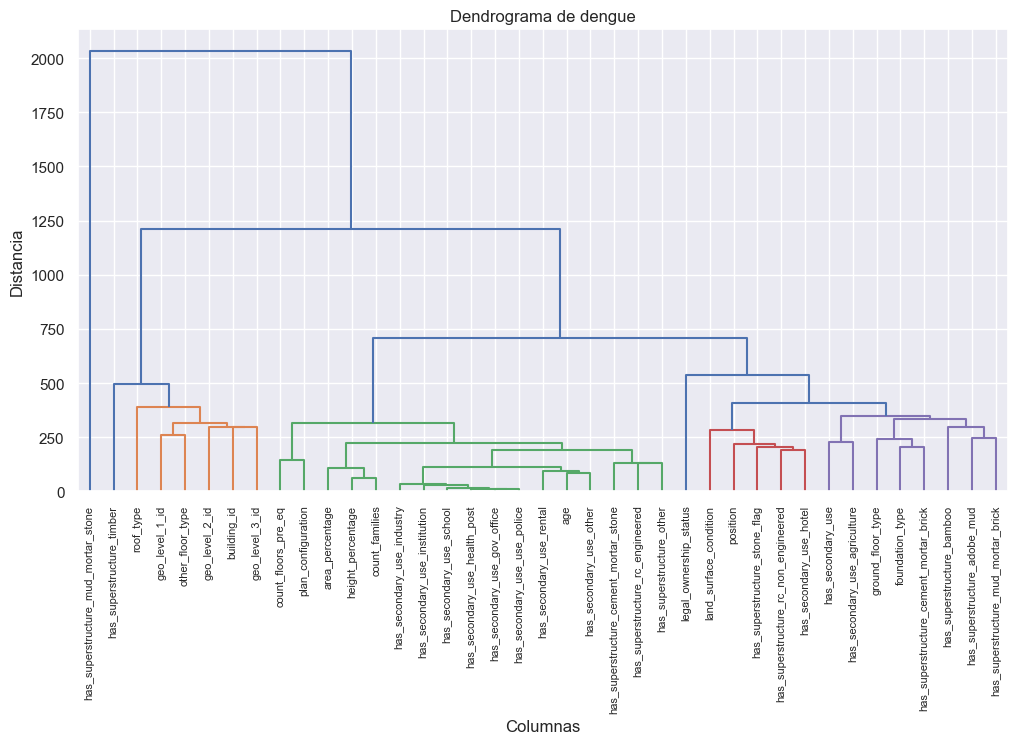

In [44]:
Dendogram(X, 400)